In [1]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torch.utils.data
import numpy as np 
import matplotlib.pyplot as plt
import Autoencoder as AE
import scipy
import scipy.interpolate

# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Reproducibility  
torch.manual_seed(0);

C:\Users\dstre\AppData\Local\Temp\ipykernel_27600\501697399.py:7: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  import matplotlib.pyplot as plt


In [2]:
### Load and Process Data ###
run_interp = True 
cyl_data = np.load('./data/cylinder/data_numpy.npy') # of shape [n_samples, (u, v, vort), n_gridpoints]
xy_coords = np.load('./data/cylinder/xy_coords.npy').T # of shape [n_gridpoints, (x, y)].T
vort_data = cyl_data[:, 2, :]

# interpolate onto structured grid
x = xy_coords[0, :]
y = xy_coords[1, :]
x_bounds = [x.min(), x.max()]
y_bounds = [y.min(), y.max()]
scaling = 20 #controls resolution of structured grid
Nx = int((x_bounds[1] - x_bounds[0]) * scaling)
Ny = int((y_bounds[1] - y_bounds[0]) * scaling)
grid_x, grid_y = np.meshgrid(np.linspace(x_bounds[0], x_bounds[1], Nx), np.linspace(y_bounds[0], y_bounds[1], Ny))

# cylinder mask 
mask = np.ones_like(grid_x)
mask[np.where(grid_x**2 + grid_y**2 < 0.5**2)] = 0

if run_interp: # takes ~3m for scaling = 20
    vort_structured = np.zeros((vort_data.shape[0], Ny, Nx))
    for i in range(vort_data.shape[0]):
        interpolated = scipy.interpolate.griddata((x,y), vort_data[i], (grid_x, grid_y), method='cubic')
        vort_structured[i] = interpolated * mask
    np.save('./data/cylinder/vort_structured{}.npy'.format(scaling), vort_structured)
else:
    vort_structured = np.load('./data/cylinder/vort_structured{}.npy'.format(scaling))

im_size = vort_structured.shape[1] * vort_structured.shape[2]

### Dataloaders ###
test_perc = 0.1
split_idx = int((1-test_perc) * vort_structured.shape[1])

batch_size = 128
vort_torch = torch.from_numpy(vort_structured).float()
vort_dset = torch.utils.data.TensorDataset(vort_torch[split_idx:, :, :])
dataloader = torch.utils.data.DataLoader(vort_dset, batch_size=batch_size, shuffle=False)

vort_dset_test = torch.utils.data.TensorDataset(vort_torch[:split_idx, :, :])
dataloader_test = torch.utils.data.DataLoader(vort_dset, batch_size=batch_size, shuffle=False)


In [3]:
### Dataloader ###
test_perc = 0.1
split_idx = int((1-test_perc) * vort_structured.shape[1])

batch_size = 128
vort_torch = torch.from_numpy(vort_structured).float()
vort_dset = torch.utils.data.TensorDataset(vort_torch[split_idx:, :, :])
dataloader = torch.utils.data.DataLoader(vort_dset, batch_size=batch_size, shuffle=False)

vort_dset_test = torch.utils.data.TensorDataset(vort_torch[:split_idx, :, :])
dataloader_test = torch.utils.data.DataLoader(vort_dset, batch_size=batch_size, shuffle=False)

Image batch: torch.Size([128, 40, 80])


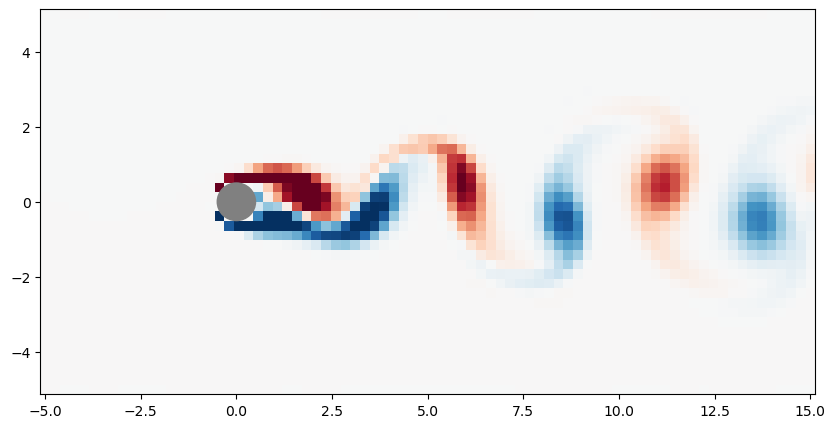

In [4]:
### Show Sample ### 
sample = next(iter(dataloader))  #grab the next batch from the dataloader
print('Image batch:', sample[0].shape) #of shape batch_size x channels x W x H (channels = 1 for this grayscale dset)  
plt.figure(figsize=(10,5))
plt.pcolormesh(grid_x, grid_y, sample[0][0], cmap='RdBu', shading='auto', vmax=2, vmin=-2)
circle = plt.Circle((0, 0), 0.5, color='grey')
ax = plt.gca()
ax.add_patch(circle)
plt.show()

In [6]:
#initialize and test networks 
#make sure to send everything to the correct device (important if you have GPU)
n_latent = int(0.01* cyl_data.shape[-1]) #use 1% of original amount of data
n_hidden = 5 #number of hidden layers 
NN_width = 1024*2  #width of the hidden layers

net = AE.AutoEncoder(im_size, n_latent, n_hidden, NN_width, taper = True, square=False).to(device)
reconst, latent = net(sample[0].to(device))
print('Reconstructed shape:', reconst.shape)
print('Latent shape:', latent.shape)

Reconstructed shape: torch.Size([128, 80000])
Latent shape: torch.Size([128, 87])


In [7]:
#training parameters
epochs = 100        #one epoch is one iteration through the entire training cylce
iters_cycle = 50    #frequency of which to log results
error = torch.nn.L1Loss() 

In [8]:
### Train Autoencoder ###
LR = 1e-4

#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.999), lr = LR)

#save losses
losses = []
lrs = []

#train
iters = 0

for epoch in range(epochs):
    #iterate through dataloader
    for batch in dataloader:
        #separate batch into labels and images
        images = batch[0].to(device)
        
        #make predictions
        reconst, latent = net(images)
        
        #calculate loss
        loss = error(reconst, images.flatten(start_dim=1))
        
        #backpropagate gradients with Adam algorithm, this is the magic of pytorch and autograd
        loss.backward()
        opt.step()
        
        #reset gradients
        net.zero_grad()
        
        #save losses
        losses.append(loss.item())

        #save learning rate
        lrs.append(opt.param_groups[0]['lr'])
        
        #log progress
        if iters%iters_cycle==0:    
            print('Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch, epochs, iters, loss.item()))
        iters +=1
    

Epoch: 0/100     Iter: 0     Loss: 0.14850565791130066
Epoch: 3/100     Iter: 50     Loss: 0.13488617539405823
Epoch: 6/100     Iter: 100     Loss: 0.12794819474220276
Epoch: 10/100     Iter: 150     Loss: 0.10471651703119278
Epoch: 13/100     Iter: 200     Loss: 0.10106001049280167
Epoch: 16/100     Iter: 250     Loss: 0.11027219146490097
Epoch: 20/100     Iter: 300     Loss: 0.0950879156589508
Epoch: 23/100     Iter: 350     Loss: 0.07169665396213531
Epoch: 26/100     Iter: 400     Loss: 0.10835827142000198
Epoch: 30/100     Iter: 450     Loss: 0.08365214616060257
Epoch: 33/100     Iter: 500     Loss: 0.062415629625320435
Epoch: 36/100     Iter: 550     Loss: 0.10727931559085846
Epoch: 40/100     Iter: 600     Loss: 0.07850319892168045
Epoch: 43/100     Iter: 650     Loss: 0.0616832934319973
Epoch: 46/100     Iter: 700     Loss: 0.10874887555837631
Epoch: 50/100     Iter: 750     Loss: 0.06878957897424698
Epoch: 53/100     Iter: 800     Loss: 0.0654316172003746
Epoch: 56/100     Iter

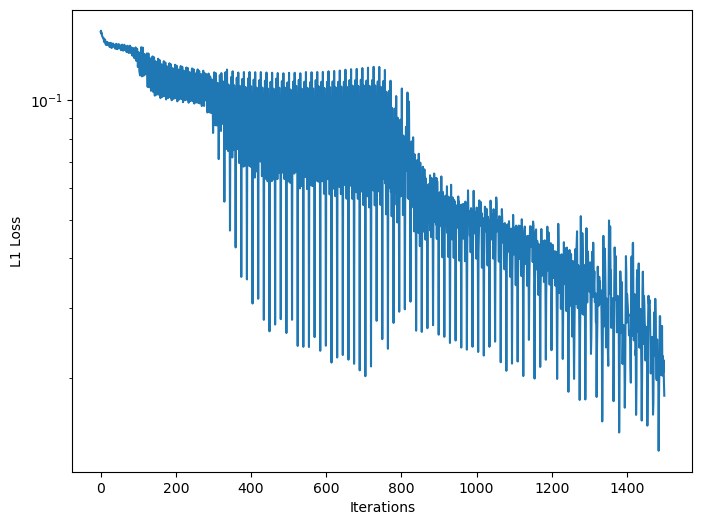

In [9]:
#plot loss curve 
plt.figure(figsize = (8,6))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('L1 Loss')
plt.yscale('log')
plt.show()

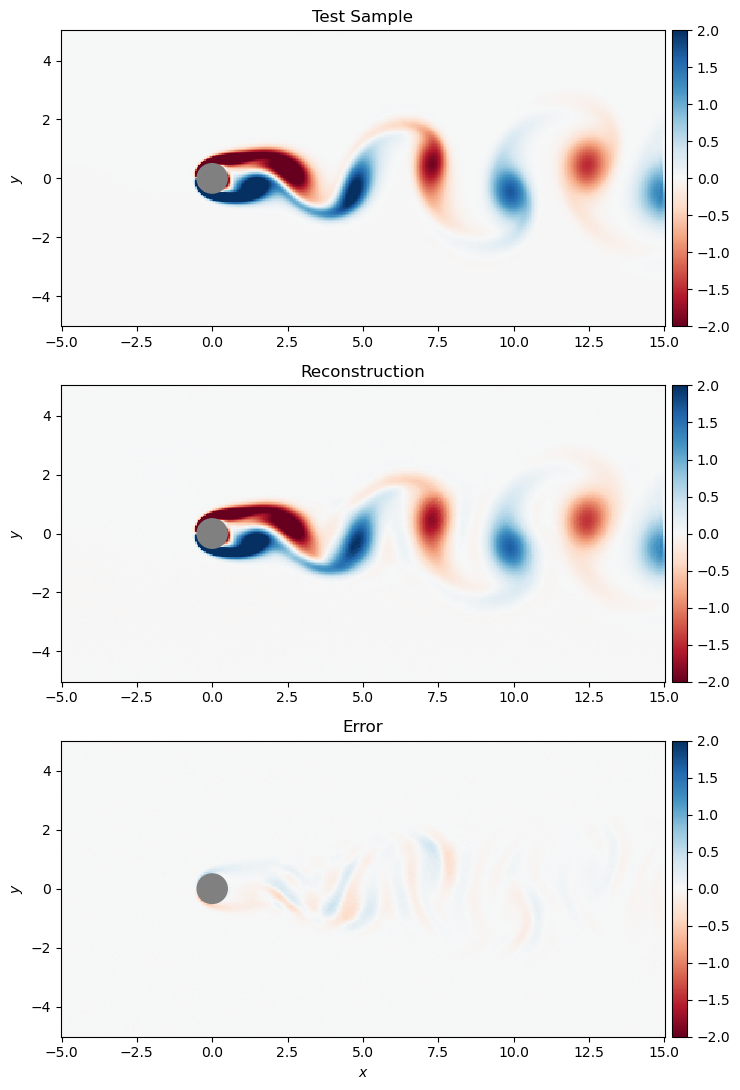

In [74]:
sample = next(iter(dataloader_test))  #grab the next batch from the dataloader
reconst, latent = net(sample[0].to(device))#[0].detach().cpu()
reconst = reconst.view(-1, Ny, Nx).detach().cpu()

fig, axs = plt.subplots(3,1, figsize=(8, 11))

# Plot sample
sample_plot = axs[0].pcolormesh(grid_x, grid_y, sample[0][0], cmap='RdBu', shading='auto', vmax=2, vmin=-2)
circle = plt.Circle((0, 0), 0.5, color='grey')
axs[0].add_patch(circle)
axs[0].set_title('Test Sample')
axs[0].set_ylabel(r'$y$')
# axs[0].set_xlabel(r'$x$')
axs[0].set_aspect('auto')

# Plot reconstruction
reconst_plot = axs[1].pcolormesh(grid_x, grid_y, reconst[0], cmap='RdBu', shading='auto', vmax=2, vmin=-2)
circle = plt.Circle((0, 0), 0.5, color='grey')
axs[1].add_patch(circle)
axs[1].set_title('Reconstruction')
axs[1].set_ylabel(r'$y$')
# axs[1].set_xlabel(r'$x$')
axs[1].set_aspect('auto')

# Calculate error
error = reconst[0] - sample[0][0]

# Plot error
#error_plot = axs[2].pcolormesh(grid_x, grid_y, error, vmin = 1e-3,cmap='plasma', shading='auto', norm = 'log')
error_plot = axs[2].pcolormesh(grid_x, grid_y, error, vmin = -2, vmax = 2,cmap='RdBu', shading='auto')
circle = plt.Circle((0, 0), 0.5, color='grey')
axs[2].add_patch(circle)
axs[2].set_title('Error')
axs[2].set_ylabel(r'$y$')
axs[2].set_xlabel(r'$x$')
axs[2].set_aspect('auto')

# Add colorbar
fig.colorbar(sample_plot, ax=axs[0], pad = 0.01)
fig.colorbar(reconst_plot, ax=axs[1], pad = 0.01)
fig.colorbar(error_plot, ax=axs[2], pad = 0.01)

plt.tight_layout()
plt.show()